In [1]:
"""
main module:
module to run the whole pipleline
"""

import os
from pathlib import Path

from src.config import load_config
from src.distance_transform import calculate_distance_tranform
from src.preprocessing import data_preprocessing_wrapper
from src.profiles import calculate_profile, vizualize_profile
from src.segmentation import segmentation_wrapper
from src.segmentation_postprocessing import postprocess_masks
from src.utils import set_root_directory

/Users/hrobar/Documents/MERCK/MSD_Projects/3D_Tumor_Lightsheet_Analysis_Pipeline/src/segmentation_postprocessing.py:28: FutureWarning: Importing from skimage.morphology.grey is deprecated. Please import from skimage.morphology instead.
  from skimage.morphology.grey import dilation


In [2]:
root_directory_path = set_root_directory()

# Config file
config_path = root_directory_path.joinpath("data/demo_study/config.json")
experiment = load_config(config_path)

MLFLOW_TRACKING_URI = root_directory_path.joinpath("data/mlruns")
MLFLOW_EXPERIMENT_NAME = "experiments"
SCRIPT_NAME = "master_script.py"

setting root directory to: /Users/hrobar/Documents/MERCK/MSD_Projects/3D_Tumor_Lightsheet_Analysis_Pipeline


In [3]:
experiment["data"]["source"]["transformed"] = experiment["data"]["source"]["raw"]
experiment["data"]["source"]["transformed"]

{'vessel': Path('/Users/hrobar/Documents/MERCK/MSD_Projects/3D_Tumor_Lightsheet_Analysis_Pipeline/data/demo_study/source/raw/vessel'), 'tumor': Path('/Users/hrobar/Documents/MERCK/MSD_Projects/3D_Tumor_Lightsheet_Analysis_Pipeline/data/demo_study/source/raw/tumor'), 'virus': Path('/Users/hrobar/Documents/MERCK/MSD_Projects/3D_Tumor_Lightsheet_Analysis_Pipeline/data/demo_study/source/raw/virus')}

In [4]:
# NOTE: To reduce the repo size, we already provided reduced data for the demo purposes
#######################################
# # DATA PREPROCESSING
# #####################################

# experiment["data"]["source"]["transformed"] = data_preprocessing_wrapper(
#     experiment["data"]["source"]["raw"]
# )

for key in experiment["data"]["source"]["transformed"]:
    experiment["data"]["source"]["transformed"][key] = Path(str(experiment["data"]["source"]["transformed"][key]).replace('raw', 'transformed/np_and_resized'))


In [5]:
#######################################
# # SEGMENTATION
# #####################################

# segmentation of blood vessels
out_path = segmentation_wrapper(
    experiment["data"]["source"]["transformed"]["vessel"],
    **experiment["segmentation_method_vessel"],
)
experiment["data"]["results"]["segmentation"]["vessel"] = out_path


# segmentation of tumors
out_path = segmentation_wrapper(
    experiment["data"]["source"]["transformed"]["tumor"],
    **experiment["segmentation_method_tumor"],
)
experiment["data"]["results"]["segmentation"]["tumor"] = out_path

# # postprocessing tumor masks
out_path = postprocess_masks(
    experiment["data"]["results"]["segmentation"]["tumor"],
    **experiment["segmentation_postprocessing_tumor"],
)
experiment["data"]["results"]["segmentation_postprocessing"][
    "tumor"
] = out_path



running segmentation_wrapper


Number of files with the folders does not match
Deleting 0 files in segment___thresholding___method-th_otsu
Done!


running thresholding




threshold th_otsu value: 778.0
Number of files with the folders does not match
Deleting 0 files in segment___thresholding___method-th_otsu
Done!


100%|██████████| 15/15 [00:00<00:00, 115.81it/s]

function thresholding took 0:00:00.284259s
function segmentation_wrapper took 0:00:00.287687s


running segmentation_wrapper


Number of files with the folders does not match
Deleting 0 files in segment___thresholding___method-th_triangle
Done!


running thresholding




threshold th_triangle value: 25.0
Number of files with the folders does not match
Deleting 0 files in segment___thresholding___method-th_triangle
Done!


100%|██████████| 15/15 [00:00<00:00, 142.69it/s]

function thresholding took 0:00:00.275563s
function segmentation_wrapper took 0:00:00.282641s


running postprocess_masks


Number of files with the folders does not match
Deleting 0 files in postprocess_masks___split_tumor_into_core_and_periphery___segment___thresholding___method-th_triangle
Done!


function postprocess_masks took 0:00:01.367196s


In [6]:
#######################################
# # DISTANCE TRANSFORM
# #####################################

out_path = calculate_distance_tranform(
    experiment["data"]["results"]["segmentation"]["vessel"],
    **experiment["distance_tranform"]["method_parameters"],
)
experiment["data"]["results"]["distance_transform"]["vessel"] = out_path





running calculate_distance_tranform


Number of files with the folders does not match
Deleting 0 files in distance_tranform___segment___thresholding___method-th_otsu
Done!
Deleting 0 files in tmp_overlapping_bricks___segment___thresholding___method-th_otsu
Done!


running _merge_with_overlap




100%|██████████| 6/6 [00:00<00:00, 61.47it/s]


function _merge_with_overlap took 0:00:00.101100s
Deleting 0 files in tmp_dt_overlapping_bricks___segment___thresholding___method-th_otsu
Done!


running _compute_distance_transform




100%|██████████| 6/6 [00:08<00:00,  1.49s/it]


function _compute_distance_transform took 0:00:08.930649s
Deleting 0 files in tmp_dt_aggregated_bricks___segment___thresholding___method-th_otsu
Done!


running _aggregate


function _aggregate took 0:00:00.247814s
Deleting 0 files in distance_tranform___segment___thresholding___method-th_otsu
Done!


running _split




100%|██████████| 3/3 [00:00<00:00, 18.33it/s]

function _split took 0:00:00.167913s
function calculate_distance_tranform took 0:00:09.459942s




running calculate_profile




100%|██████████| 12/12 [00:00<00:00, 49152.00it/s]




running rescale_column_pandas


function rescale_column_pandas took 0:00:00.000780s


running rescale_column_pandas


function rescale_column_pandas took 0:00:00.000571s


running rescale_column_pandas


function rescale_column_pandas took 0:00:00.001372s
function calculate_profile took 0:00:01.203305s


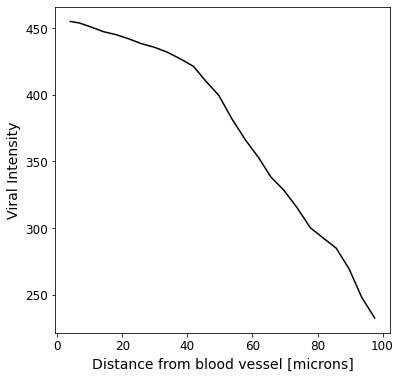

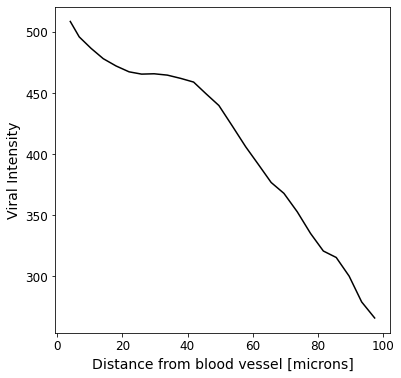

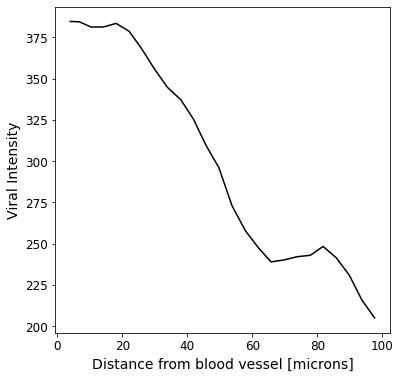

In [7]:

#######################################
# # PROFILE
# #####################################

# calculating the final profile
profiles = calculate_profile(
    experiment["data"]["source"]["transformed"]["virus"],
    experiment["data"]["results"]["distance_transform"]["vessel"],
    experiment["data"]["results"]["segmentation_postprocessing"]["tumor"],
    pixel_to_microns = 4,
    force_overwrite=True,
)

""
profile_all = vizualize_profile(profiles["all"])
profile_core = vizualize_profile(profiles["core"])
profile_periphery = vizualize_profile(profiles["periphery"])